<a href="https://colab.research.google.com/github/sakuna47/Fuzzy_logic_CW/blob/Fuzzy_code/Fuzzy_logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install -q scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tabulate import tabulate

In [11]:
# Define fuzzy input and output variables for skfuzzy
voltage_dev = ctrl.Antecedent(np.arange(0, 21, 1), 'Voltage Deviation')
freq_var = ctrl.Antecedent(np.arange(0, 0.51, 0.01), 'Frequency Variation')
load_imb = ctrl.Antecedent(np.arange(0, 31, 1), 'Load Imbalance')
phase_mis = ctrl.Antecedent(np.arange(0, 11, 1), 'Phase Mismatch')
severity = ctrl.Consequent(np.arange(0, 101, 1), 'Anomaly Severity')


In [12]:
# Tuned membership functions for better sensitivity
voltage_dev['Low'] = fuzz.trimf(voltage_dev.universe, [0, 2, 4])
voltage_dev['Medium'] = fuzz.trimf(voltage_dev.universe, [3, 7, 11])
voltage_dev['High'] = fuzz.trimf(voltage_dev.universe, [10, 15, 20])

freq_var['Stable'] = fuzz.trimf(freq_var.universe, [0, 0.05, 0.15])
freq_var['Unstable'] = fuzz.trimf(freq_var.universe, [0.1, 0.3, 0.5])

load_imb['Balanced'] = fuzz.trimf(load_imb.universe, [0, 4, 8])
load_imb['Unbalanced'] = fuzz.trimf(load_imb.universe, [7, 15, 30])

phase_mis['Aligned'] = fuzz.trimf(phase_mis.universe, [0, 2, 4])
phase_mis['Misaligned'] = fuzz.trimf(phase_mis.universe, [3, 7, 10])

severity['Low'] = fuzz.trimf(severity.universe, [0, 15, 30])
severity['Medium'] = fuzz.trimf(severity.universe, [25, 50, 75])
severity['High'] = fuzz.trimf(severity.universe, [70, 85, 100])

In [13]:
#  fuzzy rules to consider anomaly type
rules = [
    # High severity: Multiple severe conditions
    ctrl.Rule(voltage_dev['High'] & freq_var['Unstable'] & load_imb['Unbalanced'] & phase_mis['Misaligned'], severity['High']),
    ctrl.Rule(voltage_dev['High'] & freq_var['Unstable'] & load_imb['Balanced'] & phase_mis['Misaligned'], severity['High']),
    # Medium severity: Mixed conditions
    ctrl.Rule(voltage_dev['Medium'] & freq_var['Stable'] & load_imb['Unbalanced'] & phase_mis['Aligned'], severity['Medium']),
    ctrl.Rule(voltage_dev['Low'] & freq_var['Unstable'] & load_imb['Balanced'] & phase_mis['Misaligned'], severity['Medium']),
    # Low severity: Mostly normal conditions
    ctrl.Rule(voltage_dev['Low'] & freq_var['Stable'] & load_imb['Balanced'] & phase_mis['Aligned'], severity['Low']),
    # New rule: High frequency variation triggers high severity
    ctrl.Rule(freq_var['Unstable'] & voltage_dev['Medium'] & load_imb['Balanced'] & phase_mis['Aligned'], severity['High']),
    # New rule: High load imbalance triggers medium severity
    ctrl.Rule(load_imb['Unbalanced'] & voltage_dev['Low'] & freq_var['Stable'] & phase_mis['Aligned'], severity['Medium']),
    ctrl.Rule(voltage_dev['High'] & freq_var['Stable'] & load_imb['Unbalanced'] & phase_mis['Aligned'], severity['High']),
    ctrl.Rule(voltage_dev['Medium'] & freq_var['Unstable'] & load_imb['Unbalanced'] & phase_mis['Misaligned'], severity['High']),
    ctrl.Rule(voltage_dev['Low'] & freq_var['Stable'] & load_imb['Unbalanced'] & phase_mis['Aligned'], severity['Low']),
    ctrl.Rule(voltage_dev['Medium'] & freq_var['Stable'] & load_imb['Balanced'] & phase_mis['Aligned'], severity['Low']),
    ctrl.Rule(
        (voltage_dev['Low'] | voltage_dev['Medium'] | voltage_dev['High']) &
        (freq_var['Stable'] | freq_var['Unstable']) &
        (load_imb['Balanced'] | load_imb['Unbalanced']) &
        (phase_mis['Aligned'] | phase_mis['Misaligned']),
        severity['Medium']
    )
]

In [14]:
# Manual fuzzy inference engine
def manual_fuzzy_inference(volt_dev, freq_dev, load_dev, phase_dev):
    # Membership functions (same as skfuzzy for consistency)
    volt_low = fuzz.trimf(np.array([volt_dev]), [0, 2, 4])[0]
    volt_med = fuzz.trimf(np.array([volt_dev]), [3, 7, 11])[0]
    volt_high = fuzz.trimf(np.array([volt_dev]), [10, 15, 20])[0]

    freq_stable = fuzz.trimf(np.array([freq_dev]), [0, 0.05, 0.15])[0]
    freq_unstable = fuzz.trimf(np.array([freq_dev]), [0.1, 0.3, 0.5])[0]

    load_bal = fuzz.trimf(np.array([load_dev]), [0, 4, 8])[0]
    load_unbal = fuzz.trimf(np.array([load_dev]), [7, 15, 30])[0]

    phase_align = fuzz.trimf(np.array([phase_dev]), [0, 2, 4])[0]
    phase_mis = fuzz.trimf(np.array([phase_dev]), [3, 7, 10])[0]

    # Rule evaluation (min for AND, max for OR)
    rule1 = min(volt_high, freq_unstable, load_unbal, phase_mis)  # High
    rule2 = min(volt_high, freq_unstable, load_bal, phase_mis)   # High
    rule3 = min(volt_med, freq_stable, load_unbal, phase_align)  # Medium
    rule4 = min(volt_low, freq_unstable, load_bal, phase_mis)    # Medium
    rule5 = min(volt_low, freq_stable, load_bal, phase_align)    # Low
    rule6 = min(freq_unstable, volt_med, load_bal, phase_align)  # High (new: frequency-driven)
    rule7 = min(load_unbal, volt_low, freq_stable, phase_align)  # Medium (new: load-driven)
    rule8 = min(volt_high, freq_stable, load_unbal, phase_align) # High
    rule9 = min(volt_med, freq_unstable, load_unbal, phase_mis)  # High
    rule10 = min(volt_low, freq_stable, load_unbal, phase_align) # Low
    rule11 = min(volt_med, freq_stable, load_bal, phase_align)   # Low
    rule12 = max(volt_low, volt_med, volt_high) * max(freq_stable, freq_unstable) * \
             max(load_bal, load_unbal) * max(phase_align, phase_mis)  # Medium

    # Aggregate rule outputs
    severity_low = max(min(rule5, 1), min(rule10, 1), min(rule11, 1))
    severity_med = max(min(rule3, 1), min(rule4, 1), min(rule7, 1), min(rule12, 1))
    severity_high = max(min(rule1, 1), min(rule2, 1), min(rule6, 1), min(rule8, 1), min(rule9, 1))

    # Defuzzification (centroid method)
    severity_range = np.arange(0, 101, 1)
    low_memb = np.minimum(severity_low, fuzz.trimf(severity_range, [0, 15, 30]))
    med_memb = np.minimum(severity_med, fuzz.trimf(severity_range, [25, 50, 75]))
    high_memb = np.minimum(severity_high, fuzz.trimf(severity_range, [70, 85, 100]))

    aggregated = np.maximum(low_memb, np.maximum(med_memb, high_memb))
    if np.sum(aggregated) == 0:  # Handle zero aggregation
        return 50.0
    centroid = np.sum(severity_range * aggregated) / np.sum(aggregated)
    return centroid

In [15]:
# Simulate mitigation effects
def simulate_mitigation(volt_dev, freq_dev, load_dev, phase_dev, action):
    try:
        if action == "Isolate faulty section":
            return volt_dev * 0.1, freq_dev * 0.1, load_dev * 0.1, phase_dev * 0.1
        elif action == "Balance loads":
            return volt_dev, freq_dev, load_dev * 0.5, phase_dev
        elif action == "Adjust capacitor banks":
            return volt_dev * 0.8, freq_dev, load_dev, phase_dev * 0.7
        elif action == "Deploy energy storage":
            return volt_dev, freq_dev * 0.5, load_dev, phase_dev
        return volt_dev, freq_dev, load_dev, phase_dev
    except Exception as e:
        print(f"Mitigation error: {e}")
        return volt_dev, freq_dev, load_dev, phase_dev

#  evaluate anomaly function to consider anomaly type
def evaluate_anomaly(volt_dev, freq_dev, load_dev, phase_dev):
    # Validate inputs
    if not (0 <= volt_dev <= 20 and 0 <= freq_dev <= 0.5 and 0 <= load_dev <= 30 and 0 <= phase_dev <= 10):
        raise ValueError("Input values out of valid range: Voltage[0-20], Frequency[0-0.5], Load[0-30], Phase[0-10]")

    try:
        severity_score = manual_fuzzy_inference(volt_dev, freq_dev, load_dev, phase_dev)
    except Exception as e:
        print(f"Inference error: {e}")
        severity_score = 50.0

    # Determine dominant anomaly type for mitigation
    anomaly_type = "General"
    if volt_dev > 15:
        anomaly_type = "Voltage"
    elif freq_dev > 0.3:
        anomaly_type = "Frequency"
    elif load_dev > 20:
        anomaly_type = "Load"
    elif phase_dev > 7:
        anomaly_type = "Phase"

    # Map severity and anomaly type to mitigation action
    if severity_score > 70:
        action = "Isolate faulty section"
    elif severity_score > 50:
        action = "Balance loads" if anomaly_type == "Load" else "Adjust capacitor banks"
    elif severity_score > 40:
        action = "Deploy energy storage" if anomaly_type == "Frequency" else "Adjust capacitor banks"
    elif severity_score > 30:
        action = "Deploy energy storage"
    else:
        action = "Monitor without action"

    # Simulate mitigation
    new_volt, new_freq, new_load, new_phase = simulate_mitigation(volt_dev, freq_dev, load_dev, phase_dev, action)

    return severity_score, action, anomaly_type, (new_volt, new_freq, new_load, new_phase)

# Console-based interface for formatted output
def display_results(test_results):
    headers = ["Test", "Voltage (%)", "Frequency (Hz)", "Load (%)", "Phase (°)",
               "Severity", "Anomaly Type", "Action", "Post-Voltage (%)",
               "Post-Frequency (Hz)", "Post-Load (%)", "Post-Phase (°)"]
    table = []
    for i, (volt, freq, load, phase, score, action, anomaly_type, new_state) in enumerate(test_results, 1):
        table.append([
            i, volt, freq, load, phase, f"{score:.2f}", anomaly_type, action,
            f"{new_state[0]:.2f}", f"{new_state[1]:.2f}", f"{new_state[2]:.2f}", f"{new_state[3]:.2f}"
        ])
    # The problematic line has been removed or replaced with a valid indentation


    print("\n=== Fuzzy Logic Anomaly Detection Results ===")
    print(tabulate(table, headers, tablefmt="grid"))

In [16]:
# Expanded test cases
test_cases = [
    (2, 0.1, 5, 2),      # Normal operation
    (12, 0.4, 20, 8),    # Severe anomaly with phase mismatch
    (6, 0.2, 15, 5),     # Moderate anomaly
    (8, 0.3, 10, 3),     # Moderate anomaly with slight phase mismatch
    (20, 0.5, 30, 10),   # Extreme anomaly
    (0, 0, 0, 0),        # No anomaly (test false positives)
    (10, 0.25, 15, 7),   # Edge case near thresholds
    (3, 0.05, 4, 2),     # Near-normal operation
    (15, 0.45, 25, 9),   # Severe anomaly with high phase mismatch
]

# Ground truth labels (1 for anomaly, 0 for no anomaly)
true_labels = [0, 1, 1, 1, 1, 0, 1, 0, 1]
predicted_labels = []
test_results = []

# Run tests
print("Test Case Results:")
for i, (volt, freq, load, phase) in enumerate(test_cases, 1):
    try:
        score, action, anomaly_type, new_state = evaluate_anomaly(volt, freq, load, phase)
        predicted_labels.append(1 if score > 30 else 0)
        test_results.append((volt, freq, load, phase, score, action, anomaly_type, new_state))
        print(f"Test {i}: Voltage={volt}%, Frequency={freq}Hz, Load={load}%, Phase={phase}°")
        print(f"Severity Score: {score:.2f}, Anomaly Type: {anomaly_type}, Action: {action}")
        print(f"Post-Mitigation: Voltage={new_state[0]:.2f}%, Frequency={new_state[1]:.2f}Hz, "
              f"Load={new_state[2]:.2f}%, Phase={new_state[3]:.2f}°\n")
    except Exception as e:
        print(f"Test {i} failed: {e}")

# Display results in tabulated format
display_results(test_results)

Test Case Results:
Test 1: Voltage=2%, Frequency=0.1Hz, Load=5%, Phase=2°
Severity Score: 35.23, Anomaly Type: General, Action: Deploy energy storage
Post-Mitigation: Voltage=2.00%, Frequency=0.05Hz, Load=5.00%, Phase=2.00°

Test 2: Voltage=12%, Frequency=0.4Hz, Load=20%, Phase=8°
Severity Score: 74.32, Anomaly Type: Frequency, Action: Isolate faulty section
Post-Mitigation: Voltage=1.20%, Frequency=0.04Hz, Load=2.00%, Phase=0.80°

Test 3: Voltage=6%, Frequency=0.2Hz, Load=15%, Phase=5°
Severity Score: 69.90, Anomaly Type: General, Action: Adjust capacitor banks
Post-Mitigation: Voltage=4.80%, Frequency=0.20Hz, Load=15.00%, Phase=3.50°

Test 4: Voltage=8%, Frequency=0.3Hz, Load=10%, Phase=3°
Severity Score: 50.00, Anomaly Type: General, Action: Adjust capacitor banks
Post-Mitigation: Voltage=6.40%, Frequency=0.30Hz, Load=10.00%, Phase=2.10°

Test 5: Voltage=20%, Frequency=0.5Hz, Load=30%, Phase=10°
Severity Score: 50.00, Anomaly Type: Voltage, Action: Adjust capacitor banks
Post-Mitiga


Performance Metrics: Accuracy=0.67, Precision=0.67, Recall=1.00


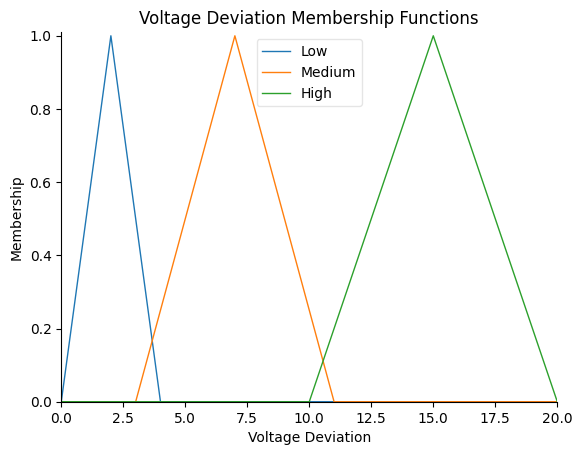

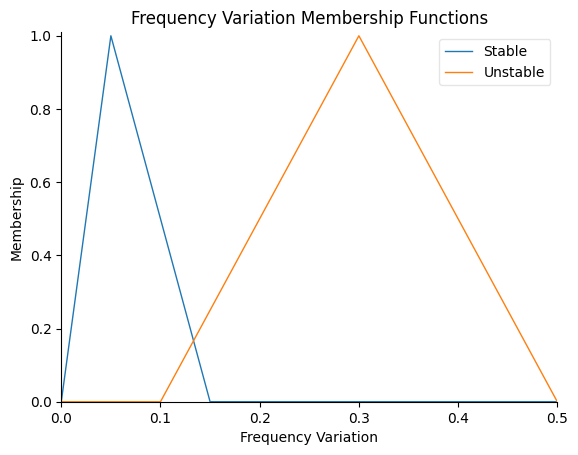

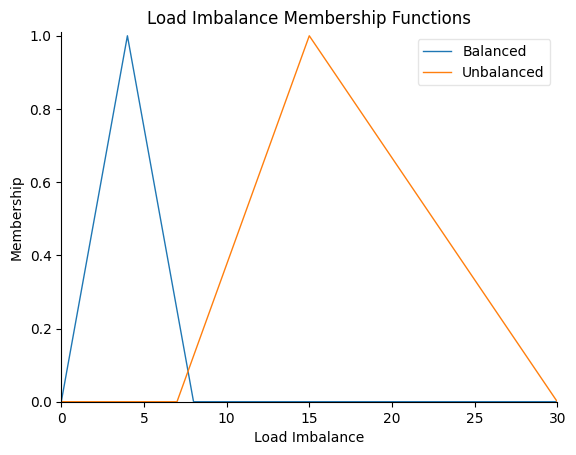

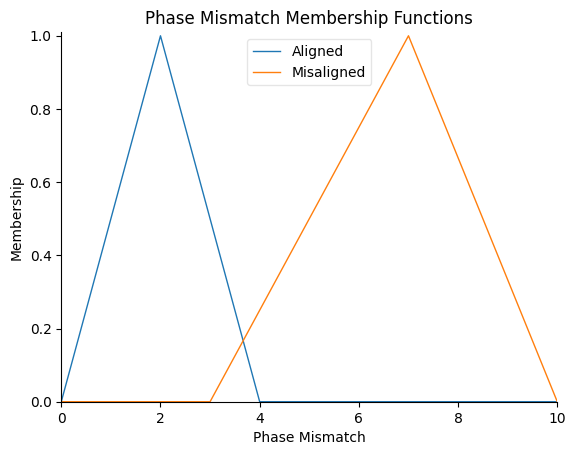

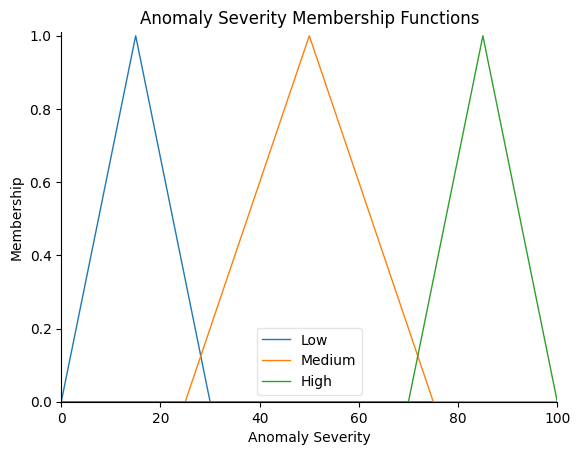

In [17]:
# Calculate performance metrics
try:
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    print(f"\nPerformance Metrics: Accuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}")
except Exception as e:
    print(f"Metrics calculation error: {e}")

# Visualize fuzzy sets (for reference)
for var in [voltage_dev, freq_var, load_imb, phase_mis, severity]:
    var.view()
    plt.title(f"{var.label} Membership Functions")
    plt.savefig(f"{var.label.lower().replace(' ', '_')}_membership.png")